In [17]:
# Core
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.neural_network import MLPClassifier

# Metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score
)

# Explainability
import shap

# Save model
import joblib

In [18]:
df = pd.read_csv('data/AIML Dataset.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [19]:
df.drop(columns="step", inplace=True)

df["balanceDiffOrig"] = df["oldbalanceOrg"] - df["newbalanceOrig"]
df["balanceDiffDest"] = df["newbalanceDest"] - df["oldbalanceDest"]

In [20]:
df_model = df.drop(["nameOrig", "nameDest", "isFlaggedFraud"], axis=1)

categorical = ["type"]
numeric = [
    "amount",
    "oldbalanceOrg",
    "newbalanceOrig",
    "oldbalanceDest",
    "newbalanceDest",
    "balanceDiffOrig",
    "balanceDiffDest"
]

y = df_model["isFraud"]
X = df_model.drop("isFraud", axis=1)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [22]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical)
    ]
)

# SUPERVISED MODELS

In [23]:
lr_pipeline = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", LogisticRegression(class_weight="balanced", max_iter=1000))
])

lr_pipeline.fit(X_train, y_train)
lr_pred = lr_pipeline.predict(X_test)

lr_auc = roc_auc_score(y_test, lr_pipeline.predict_proba(X_test)[:, 1])

In [24]:
rf_pipeline = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=100,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

rf_pipeline.fit(X_train, y_train)
rf_pred = rf_pipeline.predict(X_test)

rf_auc = roc_auc_score(y_test, rf_pipeline.predict_proba(X_test)[:, 1])

In [25]:
mlp_pipeline = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(64, 32),
        max_iter=20,
        random_state=42
    ))
])

mlp_pipeline.fit(X_train, y_train)
mlp_pred = mlp_pipeline.predict(X_test)

mlp_auc = roc_auc_score(y_test, mlp_pipeline.predict_proba(X_test)[:, 1])

In [26]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "Neural Network"],
    "ROC_AUC": [lr_auc, rf_auc, mlp_auc],
    "Recall_Fraud": [
        classification_report(y_test, lr_pred, output_dict=True)["1"]["recall"],
        classification_report(y_test, rf_pred, output_dict=True)["1"]["recall"],
        classification_report(y_test, mlp_pred, output_dict=True)["1"]["recall"]
    ]
})

results

,Model,ROC_AUC,Recall_Fraud
0,Logistic Regression,0.988647,0.939529
1,Random Forest,0.995663,0.804789
2,Neural Network,0.997421,0.671672


In [27]:
best_model_name = results.sort_values("ROC_AUC", ascending=False).iloc[0]["Model"]

if best_model_name == "Random Forest":
    best_pipeline = rf_pipeline
elif best_model_name == "Neural Network":
    best_pipeline = mlp_pipeline
else:
    best_pipeline = lr_pipeline

print("Best Model Selected:", best_model_name)

Best Model Selected: Neural Network


# ANOMALY DETECTION

In [28]:
iso_X = df_model.drop("isFraud", axis=1)
iso_X_processed = preprocessor.fit_transform(iso_X)

In [29]:
iso_forest = IsolationForest(
    contamination=0.001,
    random_state=42,
    n_jobs=-1
)

df["anomaly"] = iso_forest.fit_predict(iso_X_processed)

In [30]:
pd.crosstab(df["isFraud"], df["anomaly"])

anomaly,-1,1
isFraud,,
0,5928,6348479
1,434,7779


# SHAP EXPLAINABILITY

In [31]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

num_features = numeric
cat_features = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical)

feature_names = np.concatenate([num_features, cat_features])

In [34]:
model = best_pipeline.named_steps["clf"]

# Use a small background sample for KernelExplainer (speed)
background = shap.sample(X_train_processed, 100)

if best_model_name == "Random Forest":
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_processed)[1]

elif best_model_name == "Logistic Regression":
    explainer = shap.LinearExplainer(model, X_train_processed)
    shap_values = explainer(X_test_processed).values

else:  # Neural Network (MLP)
    explainer = shap.KernelExplainer(
        model.predict_proba,
        background
    )
    shap_values = explainer.shap_values(X_test_processed, nsamples=100)[1]

100%|██████████| 1908786/1908786 [47:01:20<00:00, 11.28it/s]      


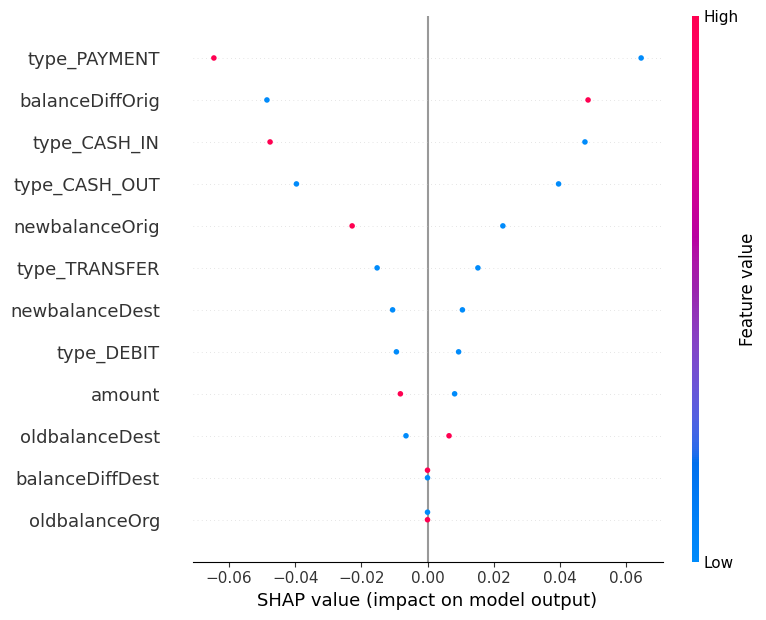

In [48]:
# --- FIX SHAP SHAPE ISSUES ---

# Convert sparse → dense
if not isinstance(X_test_processed, np.ndarray):
    X_test_processed = X_test_processed.toarray()

n_samples, n_features = X_test_processed.shape

# If shap_values is a list (per-class), try to select the array corresponding to samples
if isinstance(shap_values, list):
    sv = None
    for a in shap_values:
        a = np.asarray(a)
        if a.ndim == 2 and a.shape[0] == n_samples and a.shape[1] == n_features:
            sv = a
            break
    if sv is None:
        sv = shap_values[1] if len(shap_values) > 1 else shap_values[0]
    shap_values = np.asarray(sv)

shap_values = np.asarray(shap_values)

# Ensure shap_values has shape (n_samples_for_plot, n_features)
if shap_values.ndim == 1:
    if shap_values.size == n_features:
        shap_values = shap_values.reshape(1, -1)
    else:
        raise AssertionError("shap_values is 1D and does not match number of features.")

# Determine shap_for_plot and corresponding X_for_plot
if shap_values.shape == (n_samples, n_features):
    shap_for_plot = shap_values
    X_for_plot = X_test_processed
elif shap_values.shape[1] == n_features and shap_values.shape[0] <= n_samples:
    # shap computed on a subset of rows (subset, n_features)
    shap_for_plot = shap_values
    X_for_plot = X_test_processed[:shap_for_plot.shape[0]]
elif shap_values.shape[0] == n_features and shap_values.shape[1] <= n_samples:
    # transposed (n_features, subset) -> transpose to (subset, n_features)
    shap_for_plot = shap_values.T
    X_for_plot = X_test_processed[:shap_for_plot.shape[0]]
elif shap_values.shape[0] == n_features and shap_values.shape[1] == 2:
    # likely (n_features, n_classes) for a single sample — pick positive class
    shap_for_plot = shap_values[:, 1].reshape(1, -1)
    X_for_plot = X_test_processed[:1]
else:
    # last attempt: transpose and check
    sv_t = shap_values.T
    if sv_t.shape[0] == n_samples and sv_t.shape[1] == n_features:
        shap_for_plot = sv_t
        X_for_plot = X_test_processed
    else:
        raise AssertionError("The shape of the shap_values matrix does not match the shape of the provided data matrix.")

# Limit number of plotted samples for performance
max_plot = 1000
if shap_for_plot.shape[0] > max_plot:
    shap_for_plot = shap_for_plot[:max_plot]
    X_for_plot = X_for_plot[:max_plot]

# Rebuild feature names safely
prep = best_pipeline.named_steps["prep"]

num_features = prep.named_transformers_["num"].get_feature_names_out()
cat_features = prep.named_transformers_["cat"].get_feature_names_out(["type"])

feature_names = np.concatenate([num_features, cat_features])

# Final plot
shap.summary_plot(
    shap_for_plot,
    X_for_plot,
    feature_names=feature_names,
    show=True
)


100%|██████████| 1/1 [00:00<00:00, 14.74it/s]


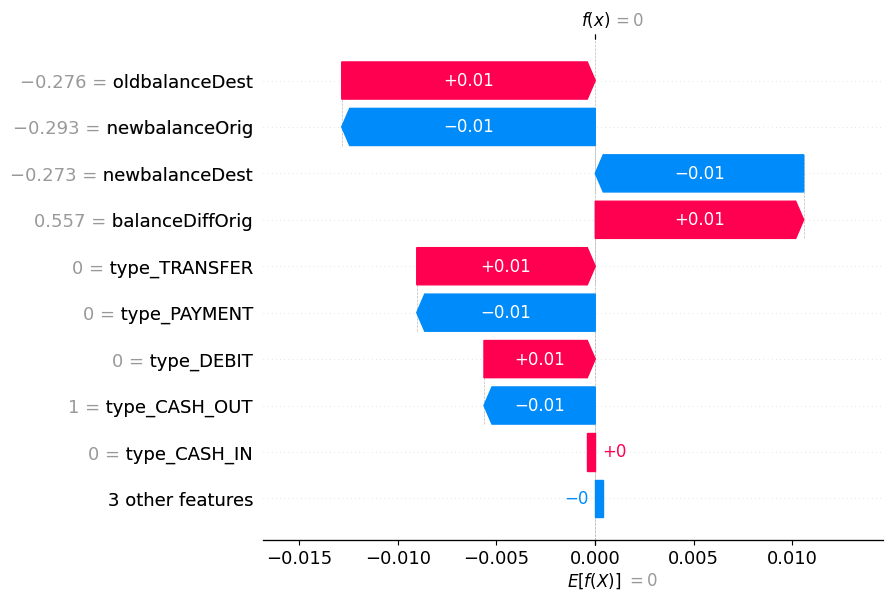

In [50]:
fraud_idx = y_test[y_test == 1].index[0]
row_pos = list(X_test.index).index(fraud_idx)

# extract the sample from the processed test matrix
sample = X_test_processed[row_pos]
if sample.ndim == 1:
    sample_2d = sample.reshape(1, -1)
else:
    sample_2d = sample

# compute shap values for the single sample (handles Kernel, Tree, Linear explainers)
if best_model_name == "Random Forest":
    vals = explainer.shap_values(sample_2d)
    sv = vals[1] if isinstance(vals, (list, tuple)) and len(vals) > 1 else np.asarray(vals)
elif best_model_name == "Logistic Regression":
    sv = explainer(sample_2d).values
else:  # Neural Network (KernelExplainer)
    vals = explainer.shap_values(sample_2d, nsamples=100)
    sv = vals[1] if isinstance(vals, (list, tuple)) and len(vals) > 1 else np.asarray(vals)

sv = np.asarray(sv)

# Normalize to 1D vector of feature contributions
if sv.ndim == 2 and sv.shape[0] == 1:
    sv_row = sv[0]
elif sv.ndim == 1 and sv.size == n_features:
    sv_row = sv
else:
    sv_row = sv.reshape(-1)[:n_features]

# determine base value safely
if best_model_name == "Random Forest":
    base_val = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value
elif best_model_name == "Logistic Regression":
    base_val = explainer.expected_value
else:
    base_val = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value

shap.plots.waterfall(
    shap.Explanation(
        values=sv_row,
        base_values=base_val,
        data=sample,
        feature_names=feature_names
    )
)

# SAVE MODEL

In [51]:
joblib.dump(best_pipeline, "best_fraud_detection_model.pkl")
joblib.dump(iso_forest, "fraud_anomaly_detector.pkl")

['fraud_anomaly_detector.pkl']

In [53]:
# %% [markdown]
# ## Manual Prediction Test (Probability + Threshold)
# This cell tests the trained model on custom transactions
# using a fraud-sensitive probability threshold.

# %%
# Define fraud threshold (business decision)
FRAUD_THRESHOLD = 0.02  # 2%

# Create test transactions (legitimate vs fraudulent)
test_cases = pd.DataFrame([
    # Legitimate transaction
    {
        "type": "PAYMENT",
        "amount": 500,
        "oldbalanceOrg": 10000,
        "newbalanceOrig": 9500,
        "oldbalanceDest": 2000,
        "newbalanceDest": 2500,
        "balanceDiffOrig": 500,
        "balanceDiffDest": 500
    },

    # Suspicious / likely fraud
    {
        "type": "TRANSFER",
        "amount": 9000,
        "oldbalanceOrg": 9000,
        "newbalanceOrig": 0,
        "oldbalanceDest": 0,
        "newbalanceDest": 0,
        "balanceDiffOrig": 9000,
        "balanceDiffDest": 0
    }
])

# Predict fraud probability
fraud_probs = best_pipeline.predict_proba(test_cases)[:, 1]

# Apply threshold
predictions = (fraud_probs >= FRAUD_THRESHOLD).astype(int)

# Combine results
results = test_cases.copy()
results["Fraud_Probability (%)"] = fraud_probs * 100
# predictions is a numpy array — use np.where (or convert to a Series) to map labels
results["Predicted_Label"] = np.where(predictions == 1, "Fraud", "Legitimate")

results


,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,balanceDiffOrig,balanceDiffDest,Fraud_Probability (%),Predicted_Label
0,PAYMENT,500,10000,9500,2000,2500,500,500,0.000048,Legitimate
1,TRANSFER,9000,9000,0,0,0,9000,0,30.110343,Fraud


Predicted Label: Fraud
Fraud Probability: 30.11%


100%|██████████| 1/1 [00:00<00:00, 14.27it/s]


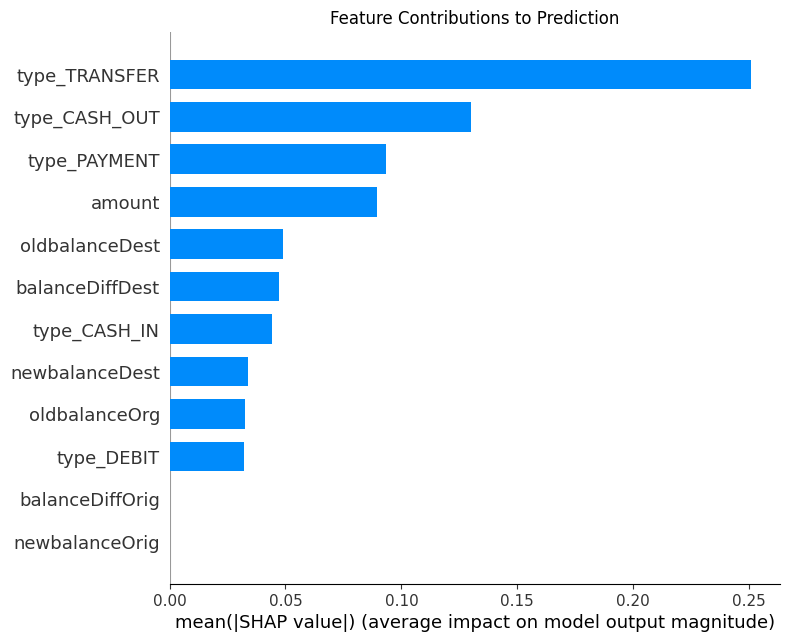

In [56]:
# %% [markdown]
# ## Test Fraud Prediction with SHAP Explanation

import shap
import matplotlib.pyplot as plt
import numpy as np

# Select a test transaction
test_case = pd.DataFrame([
    {
        "type": "TRANSFER",
        "amount": 9000,
        "oldbalanceOrg": 9000,
        "newbalanceOrig": 0,
        "oldbalanceDest": 0,
        "newbalanceDest": 0,
        "balanceDiffOrig": 9000,
        "balanceDiffDest": 0
    }
])

# Predict probability and label
FRAUD_THRESHOLD = 0.02
fraud_prob = best_pipeline.predict_proba(test_case)[:, 1][0]
prediction = int(fraud_prob >= FRAUD_THRESHOLD)
label = "Fraud" if prediction == 1 else "Legitimate"

print(f"Predicted Label: {label}")
print(f"Fraud Probability: {fraud_prob*100:.2f}%")

# ==============================
# SHAP explanation
# ==============================

# Transform input using preprocessor
X_transformed = best_pipeline.named_steps['prep'].transform(test_case)

# Prepare feature names
numeric_features = [
    "amount", "oldbalanceOrg", "newbalanceOrig",
    "oldbalanceDest", "newbalanceDest", 
    "balanceDiffOrig", "balanceDiffDest"
]
cat_features = best_pipeline.named_steps['prep'].named_transformers_['cat'].get_feature_names_out(["type"])
feature_names = numeric_features + list(cat_features)

# Choose explainer based on classifier type
clf = best_pipeline.named_steps['clf']

if "RandomForest" in type(clf).__name__:
    explainer = shap.TreeExplainer(clf)
    raw_shap = explainer.shap_values(X_transformed)
elif "LogisticRegression" in type(clf).__name__:
    explainer = shap.LinearExplainer(clf, X_transformed)
    raw_shap = explainer(X_transformed).values
else:
    # use a representative background from training set (safer than sampling the single test row)
    bg = shap.sample(X_train_processed, min(50, X_train_processed.shape[0]))
    explainer = shap.KernelExplainer(clf.predict_proba, bg)
    raw_shap = explainer.shap_values(X_transformed, nsamples=100)

# Normalize shap output to shape (n_samples, n_features)
# raw_shap may be a list (per-class) or an array with different transpositions
def normalize_shap(s, X):
    s = np.asarray(s)
    n_samples = X.shape[0]
    n_features = X.shape[1]

    # if list-like per-class, pick positive class if available
    if isinstance(s, (list, tuple)):
        if len(s) > 1:
            s = np.asarray(s[1])
        else:
            s = np.asarray(s[0])

    # handle 3D arrays like (n_samples, n_features, n_classes) or (1, n_features, n_classes)
    if s.ndim == 3:
        # prefer the positive class if present (index 1), otherwise take class 0
        if s.shape[2] > 1:
            s = s[:, :, 1]
        else:
            s = s[:, :, 0]

    # now ensure 2D (n_samples, n_features)
    if s.ndim == 1:
        if s.size == n_features:
            s = s.reshape(1, -1)
        elif s.size == n_samples:
            s = s.reshape(-1, 1)
        else:
            # fallback: try to reshape to (1, n_features) if possible
            s = s.reshape(1, -1)
    elif s.ndim == 2:
        # sometimes shape is (n_features, n_samples)
        if s.shape[0] == n_features and s.shape[1] == n_samples:
            s = s.T

    # final safety: ensure shape matches expected
    if s.ndim != 2 or s.shape[1] != n_features:
        s = s.reshape(n_samples, n_features)

    if s.shape[0] != n_samples:
        s = s[:n_samples, :]

    return s

shap_values = normalize_shap(raw_shap, X_transformed)

# Plot SHAP values
fig, ax = plt.subplots(figsize=(10, 4))
shap.summary_plot(
    shap_values,
    X_transformed,
    feature_names=feature_names,
    plot_type="bar",
    show=False
)
plt.title("Feature Contributions to Prediction")
plt.show()